# Download and extract data

In [1]:
# Clone necessary files
!git clone https://github.com/ichatnun/MCI-multiple-drawings-PyTorch.git
!mv MCI-multiple-drawings-PyTorch/* .
!rm -r MCI-multiple-drawings-PyTorch sample_data

# Create the data folder: 'MCI-multiple-drawings-PyTorch/data'
!mkdir data
!mkdir data/multiDrawingMCI2022

# Download the data and corresponding labels
!wget -P data/multiDrawingMCI2022/ https://github.com/cccnlab/MCI-multiple-drawings/raw/main/label.csv
!wget -O images.zip https://github.com/cccnlab/MCI-multiple-drawings/raw/main/images.zip
!unzip -q images.zip -d data/multiDrawingMCI2022/
!rm images.zip

Cloning into 'MCI-multiple-drawings-PyTorch'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 208 (delta 97), reused 154 (delta 50), pack-reused 0
Receiving objects: 100% (208/208), 1019.52 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (97/97), done.
--2023-09-25 02:04:16--  https://github.com/cccnlab/MCI-multiple-drawings/raw/main/label.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cccnlab/MCI-multiple-drawings/main/label.csv [following]
--2023-09-25 02:04:17--  https://raw.githubusercontent.com/cccnlab/MCI-multiple-drawings/main/label.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.gi

In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.0/660.0 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import necessary modules

In [3]:
import sys, os
import numpy as np
import torch

import matplotlib.pyplot as plt

from models.get_model import get_model
from dataloader.get_dataloaders import get_dataloaders
from utils.utils import make_exp_name, test_dataloader, test_model, save_evaluation

import lightning as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# Specify parameters

In [4]:
# Create a dictionary to store additional info
add_info = {'dataset_name': 'multiDrawingMCI',
            'idx2class_dict': {'0': 'control', '1': 'mci'},
            'healthy_threshold': 25, # MoCA score of >= 25-> healthy
            'batch_size': 4}
add_info['class_list'] = [add_info['idx2class_dict'][key] for key in add_info['idx2class_dict'].keys()]
add_info['num_classes'] = len(add_info['idx2class_dict'].keys())

# Available tasks: 'clock', 'copy', 'trail'
add_info['task_list'] = ['clock', 'copy', 'trail']

# Create the results folder
add_info['results_dir'] = os.path.join(os.getcwd(), 'results')
os.makedirs(add_info['results_dir'], exist_ok=True)

In [5]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = AttributeDict()
args.label_type = 'hard' # Available options: 'raw', 'hard', 'soft'
args.model_name = 'vgg16'
args.num_epochs = 10
args.val_fraction = 0.15
args.test_fraction = 0.15
args.random_seed = 28
args.use_pretrained_weight = True
args.freeze_backbone = False
args.num_workers = 2

# Create training, validation, and test DataLoaders

In [6]:
dataloader_dict = get_dataloaders(args, add_info)

# Test one of the created DataLoaders using the provided function

It gets a sample batch and saves the images and corresponding labels in the 'results' folder

*   test_loader_sample_data_batch.png
*   test_loader_sample_label_batch.csv



The clock data are in the range (-2.1179039478302, 2.640000104904175)
The copy data are in the range (-2.1179039478302, 2.640000104904175)
The trail data are in the range (-2.1179039478302, 2.640000104904175)


<Figure size 800x800 with 0 Axes>

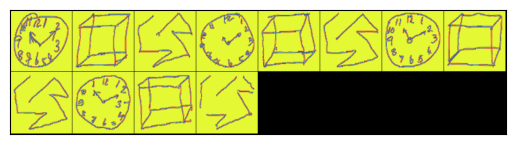

In [7]:
test_dataloader(dataloader_dict['test'],
                add_info['results_dir'],
                add_info['batch_size'],
                add_info['task_list'])

# Try getting a batch from the training DataLoader manually

In [8]:
curr_data_batch, curr_label_batch = next(iter(dataloader_dict['train']))

## Extract some information from the batch

****************** clock ******************
Data: torch.Size([4, 3, 256, 256])
Labels: torch.Size([4, 2])
The R, G, and B channels contain different values


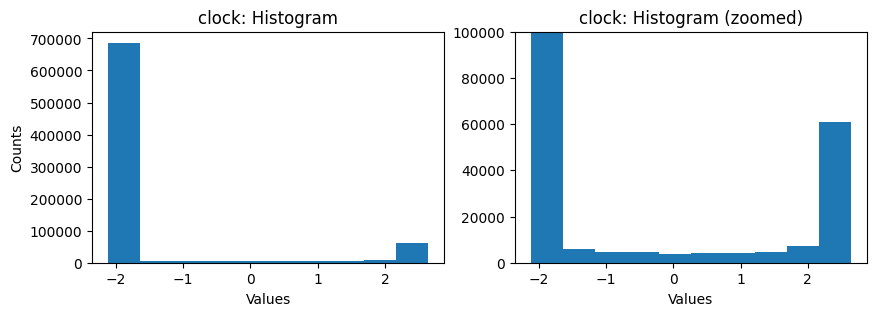

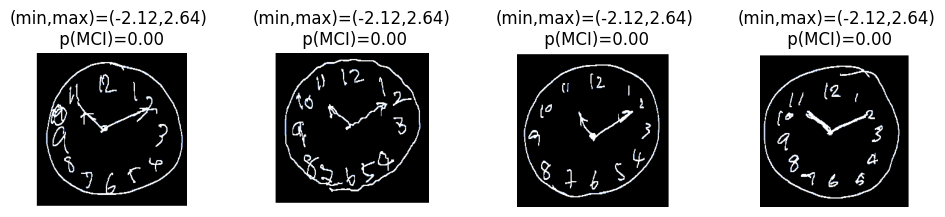



****************** copy ******************
Data: torch.Size([4, 3, 256, 256])
Labels: torch.Size([4, 2])
The R, G, and B channels contain different values


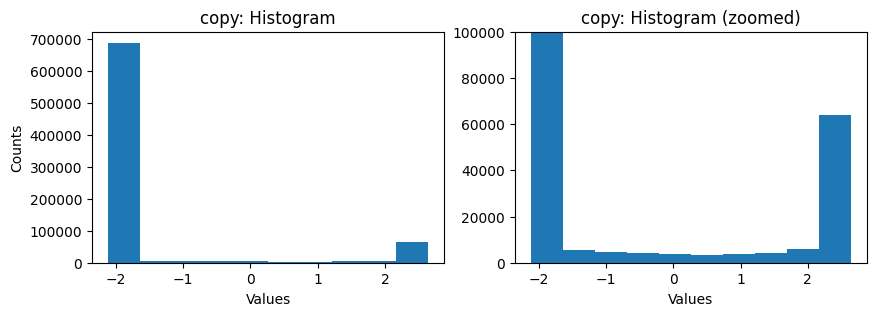

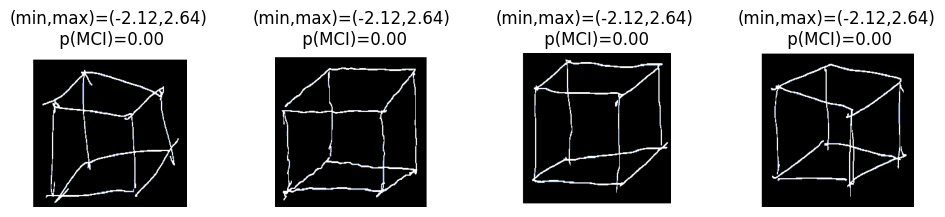



****************** trail ******************
Data: torch.Size([4, 3, 256, 256])
Labels: torch.Size([4, 2])
The R, G, and B channels contain different values


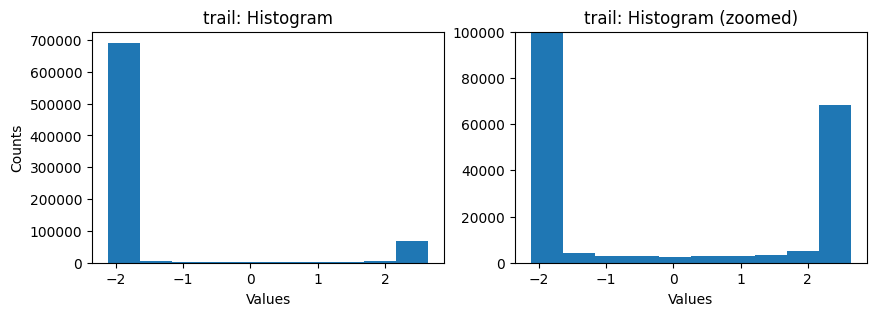

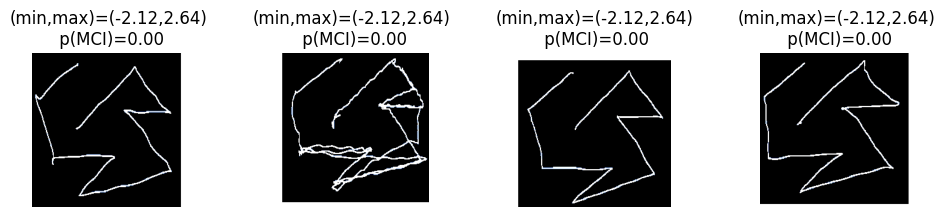

In [9]:
# Specify # of images to be displayed (per task)
num_display_imgs = min(5, add_info['batch_size'])

for curr_task in add_info['task_list']:

    print(f"****************** {curr_task} ******************")
    # Extract the data from the first task (given by add_info['task_list'][0])
    data_one_task = curr_data_batch[curr_task]

    # Check the dimensions
    print(f"Data: {data_one_task.shape}")
    print(f"Labels: {curr_label_batch.shape}")

    # Check if the R, G, and B channels are identical
    is_rg_equal = torch.equal(data_one_task[:, 0, :, :], data_one_task[:, 1, :, :])
    is_rb_equal = torch.equal(data_one_task[:, 0, :, :], data_one_task[:, 2, :, :])
    is_gb_equal = torch.equal(data_one_task[:, 1, :, :], data_one_task[:, 2, :, :])

    if is_rg_equal and is_rb_equal and is_gb_equal:
        print("The R, G, and B channels are identical")
    else:
        print("The R, G, and B channels contain different values")

    # Plot the histogram of the pixel values
    data_flatten = data_one_task.numpy().reshape(-1,)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(data_flatten)
    plt.ylabel('Counts')
    plt.xlabel('Values')
    plt.title(f"{curr_task}: Histogram")

    plt.subplot(1, 2, 2)
    plt.hist(data_flatten)
    plt.ylim(0, 1e5)
    plt.xlabel('Values')
    plt.title(f"{curr_task}: Histogram (zoomed)")

    # Display the first five images of each task in the batch
    plt.figure(figsize=(num_display_imgs*3, 2))
    for idx_img in range(num_display_imgs):

        # Extract an image
        curr_img = data_one_task.numpy()[idx_img].transpose(1, 2, 0)

        # Plot the image
        plt.subplot(1, num_display_imgs, idx_img + 1)
        plt.imshow(curr_img)
        plt.axis('off')

        if args.label_type in ['hard', 'soft']:
            plt.title(f"(min,max)=({np.min(curr_img):0.2f},{np.max(curr_img):0.2f})\n p(MCI)={curr_label_batch[idx_img, 1]:0.2f}")
        elif args.label_type == 'raw':
            plt.title(f"(min,max)=({np.min(curr_img):0.2f},{np.max(curr_img):0.2f})\n MoCA={curr_label_batch[idx_img]}")

    plt.show()
    print("\n")

# Get the base model and define the loss function

In [10]:
# Get a model
model = get_model(args.model_name, add_info["num_classes"], add_info["task_list"], args.use_pretrained_weight, args.freeze_backbone)

# Define the loss function
if args.label_type in ['hard', 'soft']:
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
elif args.label_type == 'raw':
    add_info['num_classes'] = 1
    loss_fn = torch.nn.MSELoss(reduction='mean')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.3MB/s]


# Create a Lightning module

In [11]:
class LitVGG16(pl.LightningModule):

    def __init__(self, model, loss_fn):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.softmax = torch.nn.Softmax(dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits_predicted = self.model(x) # Without softmax

        loss = self.loss_fn(logits_predicted, y)

        # Log results
        self.log("train_loss", loss)

        return loss

    def forward(self, x):
        logits_predicted = self.model(x) # Without softmax
        return self.softmax(logits_predicted)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits_predicted = self.model(x) # Without softmax

        loss = self.loss_fn(logits_predicted, y)

        # Log results
        self.log("val_loss", loss)

        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(model.parameters(),
                                lr=0.001,
                                momentum=0.9)

In [12]:
# Create the model
modelLit = LitVGG16(model, loss_fn)

# Prepare logger
logger = CSVLogger(save_dir=add_info['results_dir'])

# Prepare callbacks
checkpoint_callback = ModelCheckpoint(dirpath=add_info['results_dir'],
                                      filename='{epoch}-{val_loss:.2f}',
                                      monitor='val_loss',
                                      mode='min',
                                      save_top_k=1,
                                      every_n_epochs=1)

# Train the model

In [13]:
trainer = pl.Trainer(max_epochs=args.num_epochs,
                      logger=logger,
                      callbacks=[checkpoint_callback],
                      devices=[0],
                      log_every_n_steps=dataloader_dict['train'].__len__(),
                      accelerator="gpu")

trainer.fit(model=modelLit,
            train_dataloaders=dataloader_dict['train'],
            val_dataloaders=dataloader_dict['val'])

if torch.cuda.is_available():
    torch.cuda.empty_cache()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params
---------------------------------------------
0 | model   | multiInputVGG16 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Test the trained model and save evaluation results

In [15]:
# Load the best model
trained_model = LitVGG16.load_from_checkpoint(checkpoint_callback.best_model_path,
                                              model=model,
                                              loss_fn=loss_fn)

# Test the model
labels_true, probs_predicted = test_model(trained_model,
                                          dataloader_dict['test'],
                                          "cuda:0")

# Save evaluation metrics
save_evaluation(labels_true,
                probs_predicted,
                add_info['results_dir'],
                add_info['class_list'])

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [16]:
!cat results/eval_metrics.txt

accuracy = 0.79
precision (macro) = 0.78
recall (macro) = 0.67
f1-score (macro) = 0.69
auc = 0.79
accuracy = 0.79
precision (weighted) = 0.79
recall (weighted) = 0.79
f1-score (weighted) = 0.77
              precision    recall  f1-score   support

     control       0.79      0.95      0.87        98
         mci       0.76      0.40      0.52        40

    accuracy                           0.79       138
   macro avg       0.78      0.67      0.69       138
weighted avg       0.79      0.79      0.77       138
